In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

In [2]:
dataset = datasets.load_iris()
features = dataset.data[:, -2:]  # Petal Length and Petal Width
features = features / features.max(axis=0)
labels = dataset.target

In [3]:
def argmin_2d(matrix):
    return np.unravel_index(matrix.argmin(), matrix.shape)


def scatter(xy, **kwargs):
    xy_flat = xy.reshape(-1, 2)
    plt.gcf().set_size_inches(6, 6)
    return plt.scatter(xy_flat[:, 0], xy_flat[:, 1], **kwargs)


def imshow(map, **kwargs):
    plt.gcf().set_size_inches(6, 6)
    image = plt.imshow(map, **kwargs)
    plt.colorbar()
    return image


def distance_feature(points_set, point):
    """Distance in a feature space"""
    return np.linalg.norm(points_set - point, axis=2)


def distance_grid(grid, cell_index):
    """Distance in a grid space"""
    return np.linalg.norm(np.indices(grid.shape[:2]).T - cell_index, axis=2)

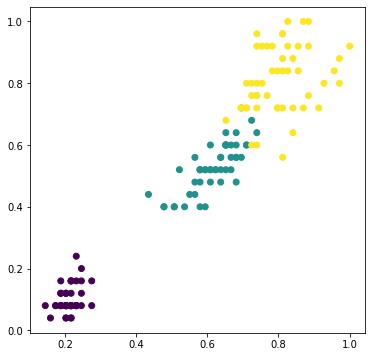

In [4]:
scatter(features, c=labels);

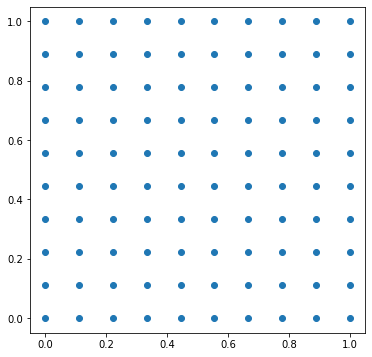

In [5]:
grid = np.mgrid[0:1:10j, 0:1:10j].T
som = grid.copy()
scatter(som);

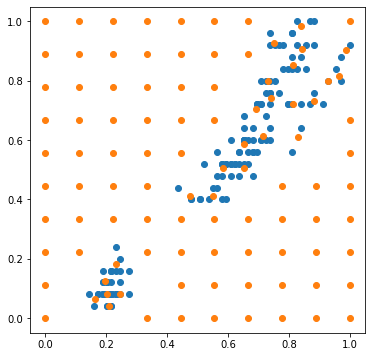

In [6]:
som = grid.copy()
rand = np.random.RandomState(seed=0)
learning_rate = 0.1
samples_num = 10000

for _ in range(samples_num):
    feature_point = features[rand.randint(features.shape[0])]
    # Беремо найближчий вузол, а не перший в околі, бо окіл може бути пустим
    cell_index = argmin_2d(distance_feature(som, feature_point))
    som[cell_index] += learning_rate * (feature_point - som[cell_index])

scatter(features)
scatter(som);

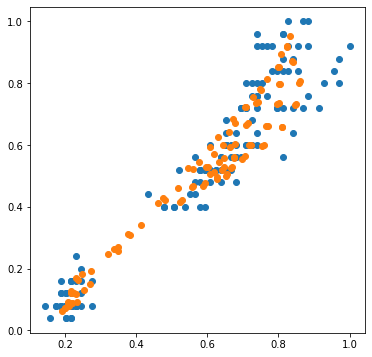

In [7]:
som = grid.copy()
rand = np.random.RandomState(seed=0)
learning_rate = 0.1
std = 1.  #
samples_num = 10000

for _ in range(samples_num):
    feature_point = features[np.random.randint(features.shape[0])]
    cell_index = argmin_2d(distance_feature(som, feature_point))
    distance_discount = np.exp(-0.5 * (distance_grid(som, cell_index) / std) ** 2)  #
    som += learning_rate * (feature_point - som) * distance_discount[:, :, np.newaxis]  #

scatter(features)
scatter(som);

In [8]:
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure()
scatter(features)
som_scatter = scatter(som, color='tab:red')
plt.close()

####################################
som = grid.copy()
rand = np.random.RandomState(seed=0)
learning_rate = 0.1
std = 1.
samples_num = 1500
####################################


def loop(i):
    global som
    if i == 0:
        return som_scatter,

    ##################################################################################
    feature_point = features[np.random.randint(features.shape[0])]
    cell_index = argmin_2d(distance_feature(som, feature_point))
    distance_discount = np.exp(-0.5 * (distance_grid(som, cell_index) / std) ** 2)
    som += learning_rate * (feature_point - som) * distance_discount[:, :, np.newaxis]
    ##################################################################################

    som_scatter.set_offsets(som.reshape(-1, 2))
    return som_scatter,


SECOND = 1000
total_frames = samples_num
total_time = 10 * SECOND

anim = animation.FuncAnimation(
    fig, loop, 
    frames=total_frames, 
    interval=total_time / total_frames, 
    blit=True,
)
HTML(anim.to_html5_video())

In [9]:
from IPython.display import HTML
from matplotlib import animation


####################################
som = grid.copy()
rand = np.random.RandomState(seed=0)
learning_rate_0 = 0.5
learning_rate_decay = 0.1
std_0 = np.sqrt(2)
std_decay = 0.07
epochs_num = 30
####################################


fig = plt.figure()
scatter(features)
som_scatter = scatter(som, color='tab:red')
plt.close()


def loop(epoch):
    global som
    if epoch == 0:
        return som_scatter,

    ######################################################################################
    learning_rate = learning_rate_0 * np.exp(-epoch * learning_rate_decay)
    std = std_0 * np.exp(-epoch * std_decay)  

    for i in rand.permutation(np.arange(features.shape[0])):
        feature_point = features[i]
        cell_index = argmin_2d(distance_feature(som, feature_point))
        distance_discount = np.exp(-0.5 * (distance_grid(som, cell_index) / std) ** 2)
        som += learning_rate * (feature_point - som) * distance_discount[:, :, np.newaxis]
    ######################################################################################

    som_scatter.set_offsets(som.reshape(-1, 2))
    return som_scatter,


SECOND = 1000
total_frames = epochs_num
total_time = 10 * SECOND

anim = animation.FuncAnimation(
    fig, loop,
    frames=total_frames,
    interval=total_time / total_frames,
    blit=True,
)
HTML(anim.to_html5_video())

In [10]:
import scipy.signal

kernel = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])

convolution = scipy.signal.convolve(
    np.pad(som, ((1, 1), (1, 1), (0, 0)), mode='edge'), 
    kernel[:, :, np.newaxis],
    mode='valid'
)
u_matrix = np.linalg.norm(convolution, axis=2)

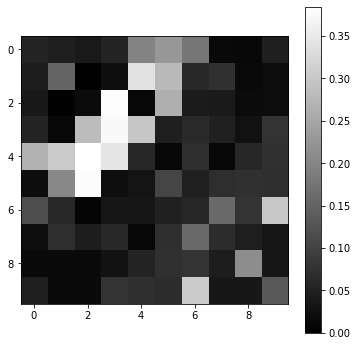

In [11]:
imshow(u_matrix, cmap='gray', vmin=0);

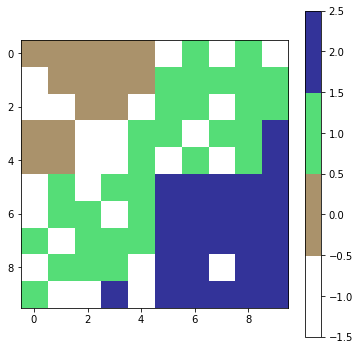

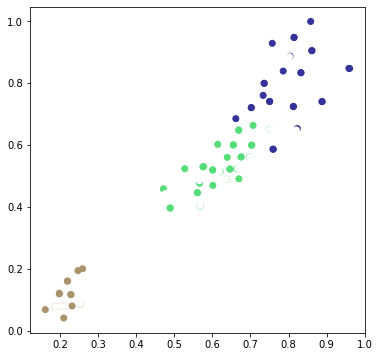

In [12]:
def most_common(lst):
    return max(set(lst), key=lst.count)


mapping = [
    [[] for j in range(som.shape[1])] 
    for i in range(som.shape[0])
]

for feature_point, label in zip(features, labels):
    cell_index = argmin_2d(distance_feature(som, feature_point))   
    mapping[cell_index[0]][cell_index[1]].append(label)

mapping = [
    [
        most_common(mapping[i][j]) if mapping[i][j] else -1
        for j in range(som.shape[1])
    ] 
    for i in range(som.shape[0])
]

cmap = plt.cm.get_cmap('terrain_r', 4)
imshow(mapping, cmap=cmap, vmin=-1.5, vmax=2.5)
plt.show()
scatter(som, cmap=cmap, c=mapping);